# Rating Distribution Analysis for GAP (on Amazon)

In [35]:
#importing required packages
import requests
from bs4 import BeautifulSoup
from textblob import TextBlob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import random
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
#intializing the options object to be fed into webdriver parameters
chrome_options=Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

In [3]:
# Add a custom User-Agent
user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
chrome_options.add_argument(f'user-agent={user_agent}')

In [4]:
'''
Adding the property to not let program close the browser window post execution
This comes quite handy while visualizing how browser content are changing during 
execution and what was the last state of browser
'''
chrome_options.add_experimental_option("detach", True)

In [5]:
#starting the chrome driver
driver=webdriver.Chrome(options=chrome_options)

In [6]:
#setting up the target website ot be scrapped
target='https://www.amazon.com/s?k=GAP+Clothing&ref=cs_503_search'

In [7]:
#getting the web page
driver.get(target)
#waiting for the page to load
time.sleep(random.uniform(2, 10))
#maximizing the browser window
driver.maximize_window()

In [8]:
# Store product data
product_data = {
    "Product Name": [],
    "Price": [],
    "Rating": [],
    "Review Count": []
}

In [9]:
page_number=1
while page_number<4:
    #selecting a product block
    products = driver.find_elements(By.XPATH, '//div[contains(@class, "s-main-slot")]/div[@data-component-type="s-search-result"]')
    # Iterate over the products and extract details
    for product in products:
        if product.find_element(By.XPATH,'.//h2[@class="a-size-mini s-line-clamp-1"]').text=='GAP':
            try:
                # Product Name
                product_name = product.find_element(By.XPATH,'.//span[@class="a-size-base-plus a-color-base a-text-normal"]').text
            except:
                product_name = 'N/A'

            try:
                # Price
                price = product.find_element(By.XPATH, './/span[@class="a-price-whole"]').text
                price_fraction = product.find_element(By.XPATH, './/span[@class="a-price-fraction"]').text
                full_price = f"{price}.{price_fraction}"
            except:
                full_price = 'N/A'

            try:
                # Rating
                rating = product.find_element(By.XPATH, './/span[@class="a-icon-alt"]').get_attribute('innerHTML').split()[0]
            except:
                rating = 'N/A'

            try:
                # Review Count
                review_count = product.find_element(By.XPATH, './/span[@class="a-size-base s-underline-text"]').text
            except:
                review_count = 'N/A'

            # Store the product details in the dictionary
            product_data["Product Name"].append(product_name)
            product_data["Price"].append(full_price)
            product_data["Rating"].append(rating)
            product_data["Review Count"].append(review_count)
        else:
            pass
    
    try:
        #incrementing the page number
        page_number+=1
        #wait till the next button appears and then locate it
        button = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.XPATH, '//a[contains(@class, "s-pagination-next")]'))
        )
        # Click the "Next" button
        button.click()
        
        #waiting for the page to load
        time.sleep(10)
    except:
        print(page_number)
        print("No 'Next' button found. Ending the loop.")
        break


In [10]:
df = pd.DataFrame(product_data)

In [11]:
df.shape

(148, 4)

In [12]:
df.tail()

,Product Name,Price,Rating,Review Count
143,Baby Boys' Short Sleeve Pocket T-Shirt,6.00,4.4,33
144,Women's Luxe Short Sleeve Crew Neck T-Shirt,25.67,4.3,131
145,Girls' Easy Linen Pant,23.60,N/A,N/A
146,Women's No Show Bikini,19.36,3.8,13
147,Men's Short Sleeve Everyday Soft Henley,12.00,4.5,9


In [13]:
# Convert 'Rating' and 'Review Count' columns to numeric, forcing errors to NaN for missing values
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df['Review Count'] = pd.to_numeric(df['Review Count'], errors='coerce')

## Plot for Top 10 Most Popular Items based on Review Count

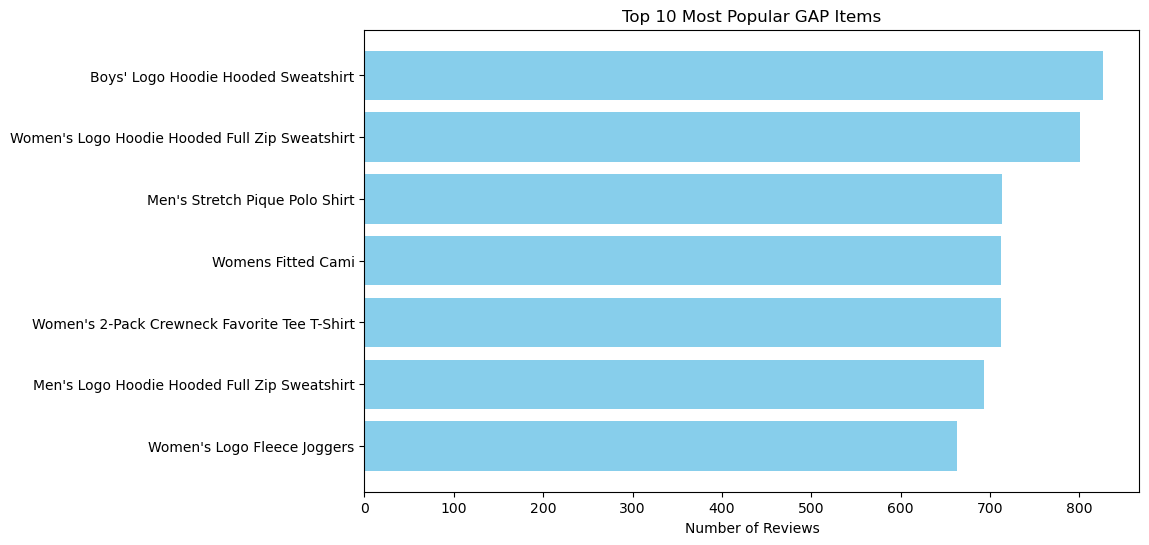

In [14]:
#visualization 1
#filtering by top review counts
top_popular_items = df.nlargest(10, 'Review Count')

plt.figure(figsize=(10, 6))
plt.barh(top_popular_items['Product Name'], top_popular_items['Review Count'], color='skyblue')
plt.xlabel('Number of Reviews')
plt.title('Top 10 Most Popular GAP Items')
plt.gca().invert_yaxis()  # Invert y-axis to show the most popular items on top
plt.show()

##  Distribution of Ratings

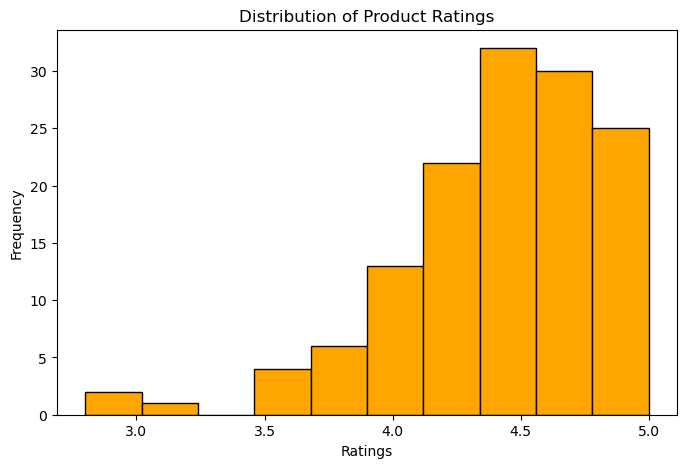

In [15]:
#visualization 2
plt.figure(figsize=(8, 5))
plt.hist(df['Rating'].dropna(), bins=10, color='orange', edgecolor='black')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.title('Distribution of Product Ratings')
plt.show()

## Items with Lowest Ratings (Badly Reviewed)

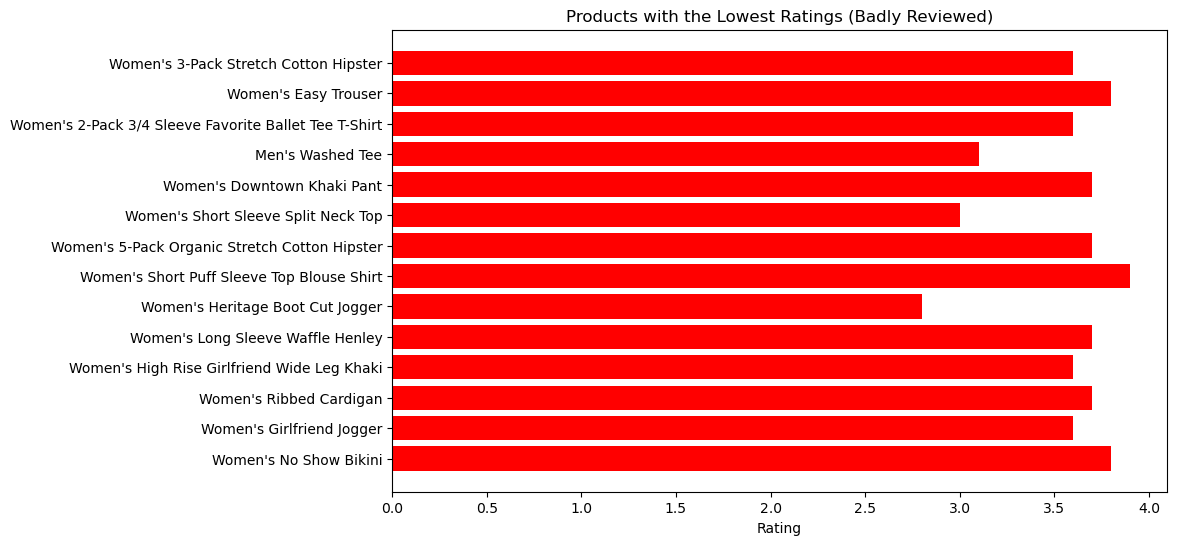

In [16]:
#visualization 3
# Assuming items with ratings below 4.0 are considered badly reviewed
badly_reviewed_items = df[df['Rating'] < 4.0]

plt.figure(figsize=(10, 6))
plt.barh(badly_reviewed_items['Product Name'], badly_reviewed_items['Rating'], color='red')
plt.xlabel('Rating')
plt.title('Products with the Lowest Ratings (Badly Reviewed)')
plt.gca().invert_yaxis()  # Invert y-axis to show the lowest ratings on top
plt.show()

In [17]:
#driver.close

<bound method WebDriver.close of <selenium.webdriver.chrome.webdriver.WebDriver (session="a5e206ea17ee17b9cdd396e643625244")>>

## Elasticity Analysis (Review Count v/s Price, Ratings & Price v/s Ratings)

In [28]:
df.dtypes

Product Name     object
Price            object
Rating          float64
Review Count    float64
dtype: object

In [39]:
#changing the datatype of Price to float
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# Data Cleaning - drop rows with missing values in relevant columns
df = df.dropna(subset=['Price', 'Review Count', 'Rating'])

#Log transformation for elasticity analysis
df['log_price'] = np.log(df['Price'])
df['log_review_count'] = np.log(df['Review Count'] + 1)  # Adding 1 to avoid log(0)
df['log_ratings'] = np.log(df['Rating'] + 1) # Adding 1 to avoid log(0)

In [40]:
df.head()

,Product Name,Price,Rating,Review Count,log_price,log_review_count,log_ratings
0,Men's Logo Hoodie Hooded Full Zip Sweatshirt,20.00,4.7,693.0,2.995732,6.542472,1.740466
3,Men's Logo Heritage Hoodie Hooded Full Zip Swe...,24.99,4.6,206.0,3.218476,5.332719,1.722767
7,Women's Favorite Crewneck Tee T-Shirt,8.00,4.4,431.0,2.079442,6.068426,1.686399
8,Boys' Logo Hoodie Hooded Full Zip Sweatshirt,17.49,4.0,591.0,2.861629,6.383507,1.609438
9,Boys' Heritage Logo Pull-on Jogger Sweatpants,14.99,4.5,212.0,2.707383,5.361292,1.704748


In [41]:
#checking is any column is having NA values before feeding the data into a regression model
print(df[['log_review_count', 'log_ratings', 'log_price']].isna().sum())

log_review_count    0
log_ratings         0
log_price           0
dtype: int64


In [46]:
#Regression Model 1 - Review Count vs. Price and Ratings
X1 = df[['log_price', 'log_ratings']]
y1 = df['log_review_count']

# Add constant (intercept) to the model
X1 = sm.add_constant(X1)

# Fit the regression model
model1 = sm.OLS(y1, X1).fit()

# Print the summary of the regression model
print("Model 1: Review Count vs Price and Ratings")
print(model1.summary())

Model 1: Review Count vs Price and Ratings
                            OLS Regression Results                            
Dep. Variable:       log_review_count   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                   0.08554
Date:                Mon, 30 Sep 2024   Prob (F-statistic):              0.918
Time:                        19:41:42   Log-Likelihood:                -216.00
No. Observations:                 111   AIC:                             438.0
Df Residuals:                     108   BIC:                             446.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const  

### Regression Summary for Model: Review Count (Demand Proxy) vs. Price and Rating

1. **R-squared**: The R-squared value is **0.002**, indicating that only **0.2%** of the variation in `log_review_count` is explained by `log_price` and `log_ratings`. This extremely low value suggests that price and ratings do not significantly explain the variation in review count (demand).

2. **Coefficients**:
   - **Intercept**: The intercept is **2.9556**, representing the expected log of review count when both price and ratings are zero. This has limited practical interpretation but helps form the regression equation.
   - **log_price**: The coefficient for `log_price` is **0.1191** with a p-value of **0.750**, indicating an **insignificant relationship** between price and review count. In elasticity terms, a 1% increase in price correlates with approximately a **0.12% increase** in review count, but this relationship is not statistically significant.
   - **log_ratings**: The coefficient for `log_ratings` is **0.6739** with a p-value of **0.736**, suggesting an **insignificant effect** on review count. A 1% increase in ratings correlates with about a **0.67% increase** in review count, but again, this is not statistically significant.

3. **P-values**:
   - Both `log_price` and `log_ratings` have high p-values (**0.750** and **0.736**, respectively), indicating that neither variable significantly affects the review count at common confidence levels (e.g., 95%).

4. **Model Fit**:
   - The adjusted R-squared value (**-0.017**) is negative, reinforcing that the model does not adequately explain the variation in review count.
   - The overall model's F-statistic p-value (**0.918**) suggests that the model is not statistically significant.

### Elasticity Insights

- **Price Elasticity**: The relationship between price and review count is weak and statistically insignificant. The small positive coefficient indicates that price changes have minimal impact on demand (as proxied by review count).
- **Ratings Elasticity**: Similarly, the positive but insignificant coefficient for ratings implies that higher ratings might correlate with a higher review count, but this effect is not supported by the data.

### Conclusion
This analysis suggests that neither price nor ratings significantly influence the review count (a proxy for demand) in this context. The demand for GAP products, as indicated by review count, is likely influenced by other factors not captured in this model.

In [45]:
#Regression Model 2 - Price vs. Ratings only
X2 = df[['log_ratings']]
y2 = df['log_price']

# Add constant (intercept) to the model
X2 = sm.add_constant(X2)

# Fit the regression model
model2 = sm.OLS(y2, X2).fit()

# Print the summary of the regression model
print("Model 2: Price vs Ratings")
print(model2.summary())

Model 2: Price vs Ratings
                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     8.210
Date:                Mon, 30 Sep 2024   Prob (F-statistic):            0.00500
Time:                        19:34:02   Log-Likelihood:                -65.563
No. Observations:                 111   AIC:                             135.1
Df Residuals:                     109   BIC:                             140.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           5.3362  

### Regression Summary for Model: Price vs. Ratings

1. **R-squared**: The R-squared value is **0.070**, indicating that about **7%** of the variation in `log_price` is explained by `log_ratings`. While this is not a strong relationship, it suggests that ratings have a small influence on the price.

2. **Coefficients**:
   - **Intercept**: The intercept is **5.3362**, which represents the expected `log_price` when `log_ratings` is zero. While this is primarily used for prediction, it doesn't provide much practical insight in this context.
   - **log_ratings**: The coefficient for `log_ratings` is **-1.4130** with a p-value of **0.005**. This negative coefficient indicates a statistically significant inverse relationship between ratings and price. In elasticity terms, a 1% increase in ratings is associated with approximately a **1.41% decrease** in price.

3. **P-values**:
   - The p-value for `log_ratings` (**0.005**) is less than 0.05, indicating that ratings have a **significant effect** on price.

4. **Model Fit**:
   - The adjusted R-squared value (**0.062**) is slightly lower than the R-squared, confirming that `log_ratings` contributes modestly to explaining the variation in `log_price`.
   - The overall model's F-statistic p-value (**0.005**) indicates that the model is statistically significant.

### Elasticity Insights

- **Ratings Elasticity**: The significant negative coefficient for `log_ratings` implies that as the ratings of a product increase, the price tends to decrease. This inverse relationship suggests that highly rated products may be priced more competitively, potentially as a strategy to drive sales volume.

### Conclusion
The analysis reveals a significant inverse relationship between ratings and price, suggesting that higher-rated products are generally offered at lower prices. However, since the R-squared is relatively low, other factors not included in this model also play a crucial role in determining product prices.